In [1]:
!pip install -q "transformers==4.45.0" "accelerate==0.33.0" "bitsandbytes==0.43.1" "safetensors>=0.3.1" "qwen-vl-utils==0.0.8"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 24.2 MB/s eta 0:00:00


In [2]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch

In [3]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    torch_dtype=torch.float16,
    device_map="auto"
)

processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}


model.safetensors.index.json:   0%|          | 0.00/56.4k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

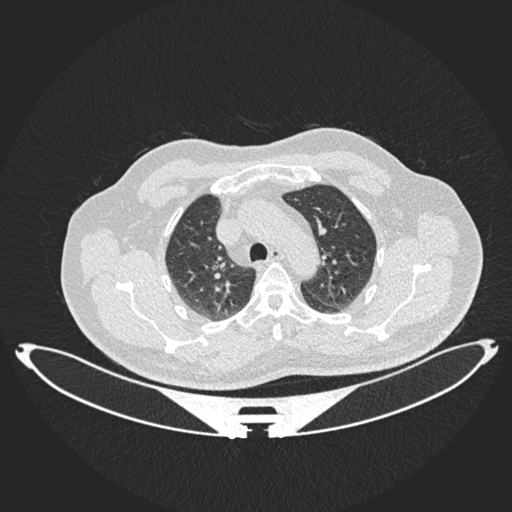

In [7]:
from PIL import Image

img = Image.open("/content/cancer.jpg")
img

In [8]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "/content/cancer.jpg",
            },
            {"type": "text", "text": "What is the type of lanug-cancer."},
        ],
    }
]

In [5]:
# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

In [10]:
print(output_text[0])

The image provided is a computed tomography (CT) scan of the chest, specifically a mediastinal window view. The scan shows the thoracic cavity, including the lungs, heart, and mediastinum. The presence of a mass in the mediastinum, which is the central part of the chest, is a common finding in various types of cancer, including lung cancer. However, without a clinical context or additional imaging, it is difficult to determine the exact type of cancer. A medical professional would need to review the scan along with the patient's medical history and symptoms to make an accurate diagnosis.


##### Multi image inference for similarities

In [11]:
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": "/content/cancer.jpg"},
            {"type": "image", "image": "/content/lungcancer.jpeg"},
            {"type": "text", "text": "Identify the similarities between these images."},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text[0])

The images provided are of different medical imaging modalities, specifically CT scans and histological slides. Here are the similarities between these images:

1. **CT Scan**:
   - **Purpose**: CT scans are used to create detailed images of the internal structures of the body, including the lungs, heart, and bones.
   - **Image Type**: CT scans are cross-sectional images that show the body in multiple planes.
   - **Purpose**: They are used to diagnose and monitor various medical conditions, such as tumors, infections, and injuries.

2. **Histological Slide**:
   - **Purpose**: Histological slides are microscopic images
